## Задача
Работа с данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются.

## Данные
Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'
### Описание полей
name - Название стартапа  
category_list - Список категорий, к которым относится стартап  
funding_total_usd - Общая сумма финансирования в USD  
status - Статус стартапа (закрыт или действующий)  
country_code - Код страны  
state_code - Код штата  
region - Регион  
city - Город  
funding_rounds - Количество раундов финансирования  
founded_at - Дата основания  
first_funding_at - Дата первого раунда финансирования  
last_funding_at - Дата последнего раунда финансирования  
closed_at - Дата закрытия стартапа (если применимо)  
lifetime - Время существования стартапа в днях  

## Подключение к kaggle

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content/gdrive/MyDrive/Kaggle'

In [4]:
!pwd

/content


In [5]:
%cd gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [6]:
!pwd

/content/gdrive/MyDrive/Kaggle


In [7]:
!kaggle competitions download -c startups-operations-close-predictions-m-1-33-ds

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1026, in competition_download_cli
    self.competition_download_files(competition, path, force,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 989, in competition_download_files
    url = response.retries.history[0].redirect_location.split('?')[0]
IndexError: tuple index out of range


In [8]:
!unzip startups-operations-close-predictions-m-1-33-ds.zip -d startup

Archive:  startups-operations-close-predictions-m-1-33-ds.zip
replace startup/kaggle_startups_sample_submit_28062024.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace startup/kaggle_startups_test_28062024.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace startup/kaggle_startups_train_28062024.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [9]:
%cd startup

/content/gdrive/MyDrive/Kaggle/startup


In [10]:
!ls

Kaggle_star				    kaggle_startups_test_28062024.csv
kaggle_startups_sample_submit_28062024.csv  kaggle_startups_train_28062024.csv
kaggle_startups_submit1_.csv		    startup
kaggle_startups_submit2_.csv		    startups-operations-close-predictions-m-1-33-ds.zip
kaggle_startups_submit3_.csv		    submit2.csv


## Загрузка библиотек

In [11]:
# устанавливаем библиотеку phik
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 4.8 MB/s eta 0:00:00


In [12]:
!pip install imblearn -q

In [13]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [14]:
pip install optuna-integration -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.6 MB/s eta 0:00:00


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold


import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution

from sklearn.model_selection import cross_val_score


from sklearn.compose import ColumnTransformer

from sklearn.ensemble import HistGradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
    roc_auc_score)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder,
    OneHotEncoder
    )

## Загрузка данных и разведочный анализ

In [16]:
parse_date_train = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
parse_date_test = ['first_funding_at', 'last_funding_at']

In [17]:
train = pd.read_csv('kaggle_startups_train_28062024.csv', parse_dates=parse_date_train)
test = pd.read_csv('kaggle_startups_test_28062024.csv', parse_dates=parse_date_test)

In [18]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [19]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [20]:
train.head(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


In [21]:
test.head(5)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [22]:
    def dataframe_info(df):
        ''' Вывод информации о датафрейме `df`. Функционал схож с методом `pd.DataFrame.info()`

        Дополнительно: вывод процента заполненных (non-null) значений, количестве дублей
        '''
        info = (pd.DataFrame({
            'notNA': df.count(), 'notNA, %': df.count()/df.shape[0]*100,
            'dtype': df.dtypes})
            .style.bar(subset='notNA, %', vmin=0, color='lightblue')
            .format("{:.2f}", subset=['notNA, %'])
        )
        print('DataFrame shape  : {} rows, {} columns'.format(
            df.shape[0], df.shape[1]))
        print('Memory usage     : {:.2f} MB'.format(
            df.memory_usage().sum()/1024/1024))
        print('Duplicates count :', df.duplicated().sum())
        return info

In [23]:
#создадим функцию которая ищет дубликаты и удаляет их.
def drop_duplicates(df):
    '''Показывает количество дубликатов и при необходимости удаляет'''
    duplicated = df.duplicated().sum()
    print(f'Найдено {duplicated} дублей')
    if duplicated > 0:
        df = df.drop_duplicates()
        duplicated = df.duplicated().sum()
        print(f'После удаления осталось {duplicated} дублей')
    return df

In [24]:
# собственная функция для анализа числовых признаков
def hist_box_func(data):
    '''
    Принимает переменную, содержащую столбцы с числовыми данными.
    Если столбцов больше одного, то применять через цикл, перебирая
    каждый столбец данной функцией в теле цикла.

    Args:
        data (class 'pandas.core.frame.DataFrame', class 'pandas.core.series.Series') - переменная с числовыми столбцами

    Returns:
        hist() - вывод гистограммы с распределением наблюдений в столбце
        boxplot() - вывод ящика с усами
        describe() - вывод описательной статистики столбца
    '''
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.hist(data, bins=30, ec='black', lw=1, color='khaki')
    plt.title('Распределение', size=15)
    plt.ylabel('Частота', size=12)
    plt.grid(linestyle='dashed')
    plt.subplot(1,2,2)
    plt.boxplot(data, vert=False)
    plt.title('Ящик с усами', size=15)
    plt.grid(linestyle='dashed')
    plt.show()
    print('Описательная статистика:')
    print(data.describe())

In [25]:
# собственная функция для преобразования категориального признака с двумя значениями в числовой бинарный признак
def to_binary_func(value):
    '''
    Принимает отдельный столбец из фрейма данных, содержащий категориальные значения.
    Предварительно необходимо задать переменные:
    cat_value_one (будет преобразовано в 1),
    cat_value_two (будет преобразовано в 0),
    и сохранить в них категориальные значения исходного pandas.Series.

    Args:
        value (pandas.core.series.Series) - переменная с категориальными значениями

    Returns:
        Столбец с преобразованными значениями (0, 1)
    '''
    try:
        if value == cat_value_one:
            return 1
        elif value == cat_value_two:
            return 0
    except:
        return 'Error'

In [26]:
# собственная функция для преобразования числового бинарного признака в бинарный категориальный
def to_cat_func(value):
    '''
    Принимает отдельный столбец из фрейма данных, содержащий числовой бинарный признак.
    Предварительно необходимо задать категориальные переменные:
    cat_value_one (на что будет преобразована 1),
    cat_value_two (на что будет преобразован 0).

    Args:
        value (pandas.core.series.Series) - переменная с числовыми значениями

    Returns:
        Столбец с преобразованными значениями (cat_value_one, cat_value_two)
    '''
    try:
        if value == 1:
            return cat_value_one
        elif value == 0:
            return cat_value_two
    except:
        return 'Error'

In [27]:
# создадиим линию для разделения разделов и датафреймов
line_1 = '-'*127

In [28]:
dataframe_info(train)

DataFrame shape  : 52516 rows, 13 columns
Memory usage     : 5.21 MB
Duplicates count : 0


,notNA,"notNA, %",dtype
name,52515,100.00,object
category_list,50051,95.31,object
funding_total_usd,42447,80.83,float64
status,52516,100.00,object
country_code,47014,89.52,object
state_code,45753,87.12,object
region,46157,87.89,object
city,46157,87.89,object
funding_rounds,52516,100.00,int64
founded_at,52516,100.00,datetime64[ns]


In [29]:
drop_duplicates(train)

Найдено 0 дублей


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT


- В строке с индексом номео 3 видим что есть пропуски country_code, state_code, region, city, т.е мы абсолютно не понимае их местоположение, запомним это и далее обработаем.

In [30]:
dataframe_info(test)

DataFrame shape  : 13125 rows, 11 columns
Memory usage     : 1.10 MB
Duplicates count : 0


,notNA,"notNA, %",dtype
name,13125,100.00,object
category_list,12534,95.50,object
funding_total_usd,10547,80.36,float64
country_code,11743,89.47,object
state_code,11430,87.09,object
region,11536,87.89,object
city,11538,87.91,object
funding_rounds,13125,100.00,int64
first_funding_at,13125,100.00,datetime64[ns]
last_funding_at,13125,100.00,datetime64[ns]


## Предобработка данных

In [31]:
# заменим пропущенные значения признака funding_total_usd на медианное значение
train['funding_total_usd'] = train['funding_total_usd'].fillna(train['funding_total_usd'].median())
#dataframe_info(train)

In [32]:
test['funding_total_usd'] = test['funding_total_usd'].fillna(test['funding_total_usd'].median())

In [33]:
# изменим форматы
train['funding_total_usd'] = pd.to_numeric(train['funding_total_usd'], errors='coerce')
train['funding_rounds'] = pd.to_numeric(train['funding_rounds'], errors='coerce')
#dataframe_info(train)

In [34]:
test['funding_total_usd'] = pd.to_numeric(test['funding_total_usd'], errors='coerce')
test['funding_rounds'] = pd.to_numeric(test['funding_rounds'], errors='coerce')

In [35]:
# количество уникальных категорий очень много, при кодировании OHE  будет слишком много столбцов
train['category_list'].nunique()

22105

In [36]:
test['category_list'].nunique()

6206

In [37]:
# пока постараемся не удалять признаки, сохраним как можно больше, заменим пустые значения на unknown
train['category_list'] = train['category_list'].fillna('unknown')

In [38]:
test['category_list'] = test['category_list'].fillna('unknown')

In [39]:
dataframe_list = [train, test]

In [40]:
def show_data(dataframe_list):
    for i in dataframe_list:
        print([x for x in globals() if globals()[x] is i][0])
        print(line_1)
        print('Количество уникальных наименований категорий стартапов:', i["category_list"].apply("nunique"))
        display(i.sample(10, random_state=RANDOM_STATE)['category_list'])
        print()

In [41]:
show_data(dataframe_list)

train
-------------------------------------------------------------------------------------------------------------------------------
Количество уникальных наименований категорий стартапов: 22106


19273                                                                             Software
52382                                                    Apps|Software|Software Compliance
543                                                                            Games|Video
43294                                    Customer Service|Customer Support Tools|Utilities
34941                                                                             Security
19756                                                                         Media|Mobile
46500                                                                          Advertising
33089                                                                              unknown
9433     E-Commerce|Green|Natural Resources|Organic|Subscription Businesses|Sustainability
30402                                                        Coupons|Curated Web|Discounts
Name: category_list, dtype: object


test
-------------------------------------------------------------------------------------------------------------------------------
Количество уникальных наименований категорий стартапов: 6207


4975                                                                    Enterprise Software
11026                                                                                 Games
11797                        Artists Globally|Concerts|Events|Social Media|Ticketing|Travel
8015                                                                            Curated Web
10972                                                                   Education|Real Time
7628                                                           Apps|Communities|Photography
11275                                                                               unknown
2316                                                                              Analytics
5862     Brand Marketing|Consumers|Curated Web|Lifestyle|Media|Retail|Shopping|Social Media
6041                                                     Banking|Finance|Financial Services
Name: category_list, dtype: object

In [42]:
for i in dataframe_list:
    i.loc[i['category_list'].str.contains('\|', na=False), 'category_list'] = (i['category_list'].str.split('|').str[0] + ' Многопрофильный')

In [43]:
# снизили количество уникальных категорий
train['category_list'].nunique()

1129

In [44]:
test['category_list'].nunique()

793

In [45]:
# Преобразование столбца last_funding_at с датами из строки в datetime
train['last_funding_at_date'] = pd.to_datetime(train['last_funding_at'])
# Удалим столбец last_funding_at
#del train['last_funding_at']
#train.info()

In [46]:
test['last_funding_at_date'] = pd.to_datetime(test['last_funding_at'])

In [47]:
#Преобразуем даты в числовой формат, чтобы использовать в качестве категориальных признаков
min_date = train['last_funding_at'].min()
train['last_funding_at_days'] = (train['last_funding_at'] - min_date).dt.days

In [48]:
min_date_test = test['last_funding_at'].min()
test['last_funding_at_days'] = (test['last_funding_at'] - min_date_test).dt.days

In [49]:
print(train['country_code'].value_counts())
print(line_1)
country_moda_train = train['country_code'].mode().iloc[0]
train['country_code'] = train['country_code'].fillna(country_moda_train)
print(f'Осталось пропущенных значений: {train["country_code"].isna().sum()}')

country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: count, Length: 134, dtype: int64
-------------------------------------------------------------------------------------------------------------------------------
Осталось пропущенных значений: 0


In [50]:
print(test['country_code'].value_counts())
print(line_1)
country_moda_test = train['country_code'].mode().iloc[0]
test['country_code'] = test['country_code'].fillna(country_moda_test)
print(f'Осталось пропущенных значений: {test["country_code"].isna().sum()}')

country_code
USA    7428
GBR     725
CAN     369
IND     307
CHN     301
       ... 
MKD       1
BHR       1
VEN       1
DMA       1
ZMB       1
Name: count, Length: 96, dtype: int64
-------------------------------------------------------------------------------------------------------------------------------
Осталось пропущенных значений: 0


In [51]:
# заменим пропущенные значения признака funding_total_usd на медианное значение
train['funding_total_usd'] = train['funding_total_usd'].fillna(train['funding_total_usd'].median())
#dataframe_info(train)

In [52]:
train['funding_total_usd'] = pd.to_numeric(train['funding_total_usd'], errors='coerce')
train['funding_rounds'] = pd.to_numeric(train['funding_rounds'], errors='coerce')

In [53]:
test['funding_total_usd'] = pd.to_numeric(test['funding_total_usd'], errors='coerce')
test['funding_rounds'] = pd.to_numeric(test['funding_rounds'], errors='coerce')

In [54]:
train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,last_funding_at_date,last_funding_at_days
0,Lunchgate,Online Reservations Многопрофильный,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2014-12-01,13714
1,EarLens,Manufacturing Многопрофильный,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,2014-02-25,13435
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,2014-07-02,13562
3,Sancilio and Company,Health Care,22250000.0,operating,USA,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,2014-07-18,13578
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,2012-02-01,12680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,2000000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT,2014-03-01,13439
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT,2014-03-07,13445
52513,Taskforce,Email Многопрофильный,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT,2011-01-01,12284
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT,2004-03-01,9787


In [55]:
# Преобразуем столбец
train['closed_at_date'] = pd.to_datetime(train['closed_at'])
# Заполняем пропуски
train['closed_at_date'].fillna(pd.Timestamp('2018-01-01'), inplace=True)
# Удалим столбец closed_at
del train['closed_at']

#train.info()
#train.head(5)

In [56]:
# добавим новый столбец
train['lifetime'] = (train['closed_at_date'] - train['founded_at']).dt.days

Исследовательский анализ числовых данных train

Столбец "funding_total_usd"


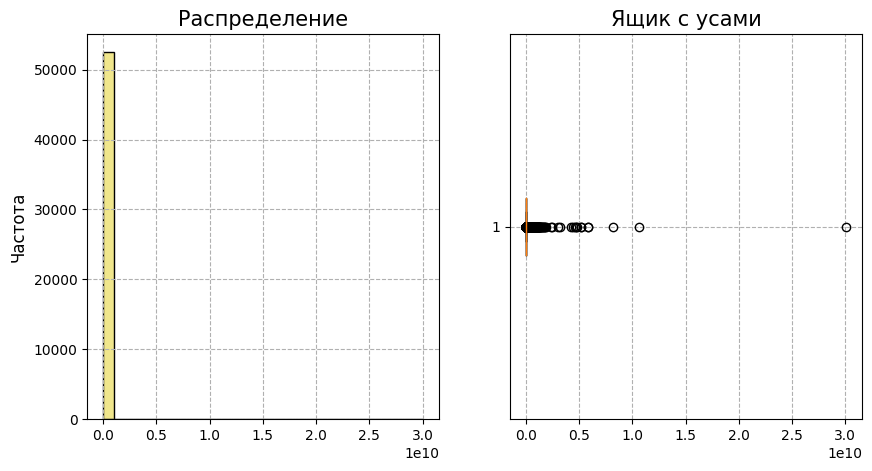

Описательная статистика:
count    5.251600e+04
mean     1.513232e+07
std      1.683466e+08
min      1.000000e+00
25%      5.297212e+05
50%      2.000000e+06
75%      6.788929e+06
max      3.007950e+10
Name: funding_total_usd, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
Столбец "funding_rounds"


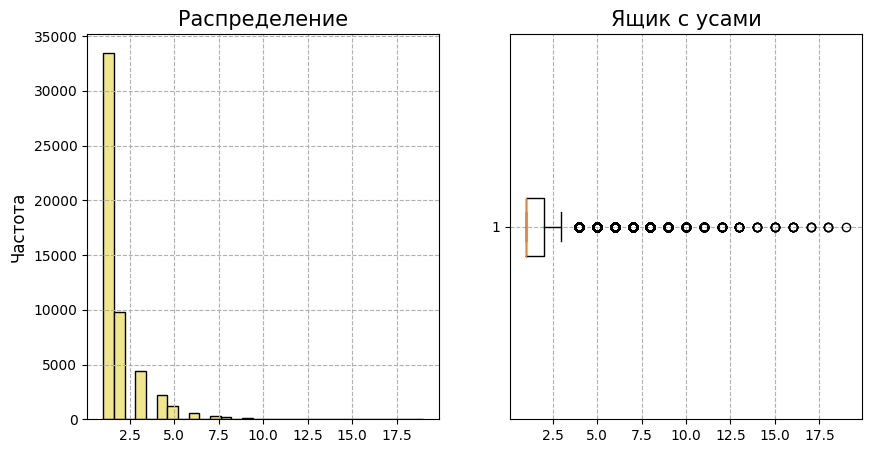

Описательная статистика:
count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
Столбец "last_funding_at_days"


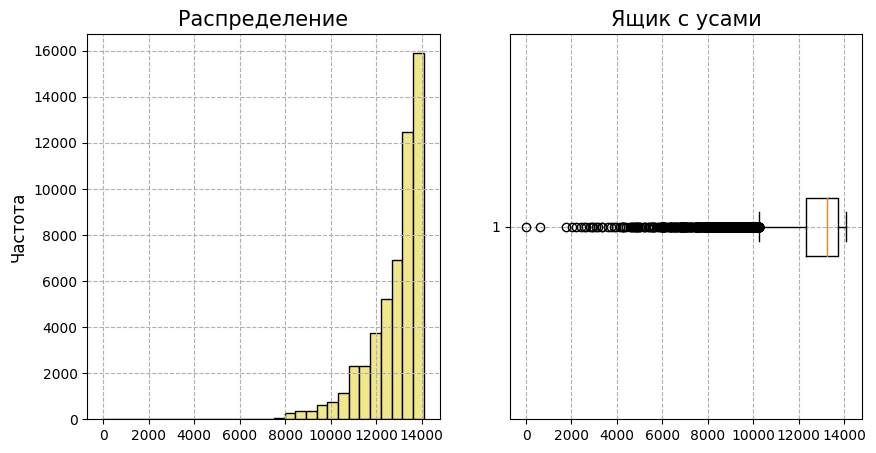

Описательная статистика:
count    52516.000000
mean     12827.687295
std       1222.569324
min          0.000000
25%      12315.000000
50%      13256.000000
75%      13700.000000
max      14085.000000
Name: last_funding_at_days, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
Столбец "lifetime"


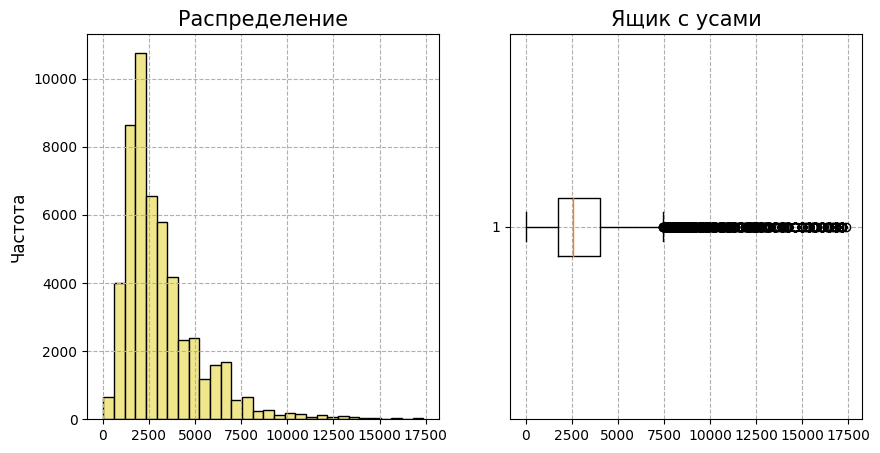

Описательная статистика:
count    52516.000000
mean      3140.828129
std       2147.821070
min         19.000000
25%       1739.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------


In [57]:
# создаём переменную, сожержащую только числовые столбцы (без id)
train_num = train[train.select_dtypes(include='number').columns]

# применяем функцию hist_box_func
print('Исследовательский анализ числовых данных train\n')
for i in train_num:
    print(f'Столбец "{i}"')
    hist_box_func(train_num[i])
    plt.show()
    print(line_1)

In [58]:
# удалим аномально высокое значение
train = train.loc[train['funding_total_usd'] != 30079503000.0]
#train['funding_total_usd'].describe()

Соотношение классов признака "status" (в %):
status
operating    0.91
closed       0.09
Name: proportion, dtype: float64


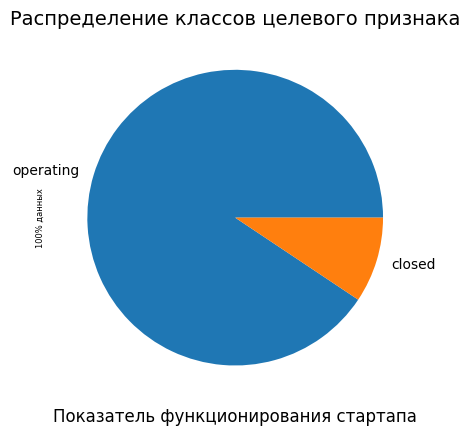

In [59]:
# проверяем целевой признак на дисбаланс классов
print('Соотношение классов признака "status" (в %):')
print(round(train.status.value_counts(normalize=True), 2))

# визуализируем на графике
train.status.value_counts(normalize=True).plot(kind='pie')
plt.title('Распределение классов целевого признака', size=14)
plt.xlabel('Показатель функционирования стартапа', size=12)
plt.ylabel('100% данных', size=6)
plt.xticks(rotation=0);

In [60]:
interval_cols = ['funding_total_usd']

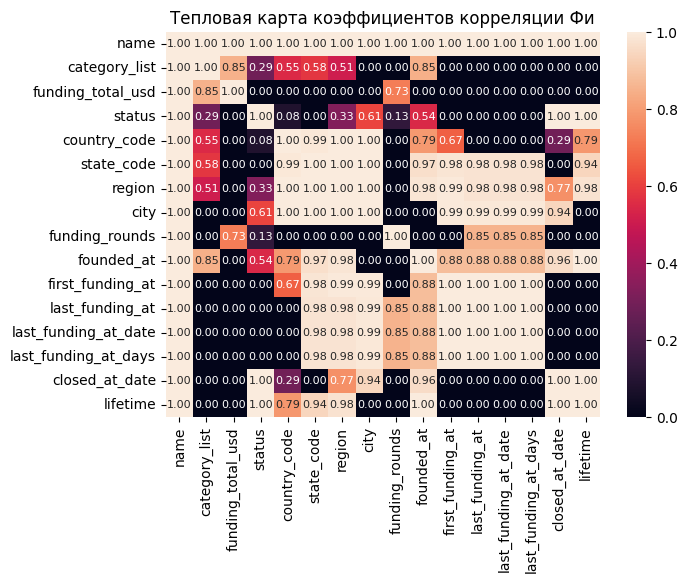

In [61]:
plt.figure(figsize=(7, 5))
sns.heatmap(train.sample(500, random_state=RANDOM_STATE).phik_matrix(interval_cols=interval_cols),\
            annot=True, fmt='.2f', annot_kws={"fontsize":8})
plt.title('Тепловая карта коэффициентов корреляции Фи');

## Подготовка данных к обучению

In [62]:
# с помощью собственной функции преобразуем категориальные значения 'status' в числовые
# 'closed' преобразуем в 1
# 'operating' преобразуем в 0

# зададим переменные для преобразования
cat_value_one = 'closed'
cat_value_two = 'operating'

# перезапишем столбец 'покупательская_активность' с помощью функции to_binary_func
train['status'] = train['status'].apply(to_binary_func)

# проверяем
print(train['status'].value_counts())
train.head()

status
0    47598
1     4917
Name: count, dtype: int64


<ipython-input-62-a403444a5a32>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['status'] = train['status'].apply(to_binary_func)


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,last_funding_at_date,last_funding_at_days,closed_at_date,lifetime
0,Lunchgate,Online Reservations Многопрофильный,828626.0,0,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2014-12-01,13714,2018-01-01,2998
1,EarLens,Manufacturing Многопрофильный,42935019.0,0,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2014-02-25,13435,2018-01-01,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,0,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2014-07-02,13562,2018-01-01,4383
3,Sancilio and Company,Health Care,22250000.0,0,USA,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2014-07-18,13578,2018-01-01,5114
4,WireTough Cylinders,Manufacturing,2000000.0,0,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2012-02-01,12680,2018-01-01,2791


In [63]:
drop_columns = ['name', 'state_code', 'city', 'region', 'founded_at', 'last_funding_at', 'last_funding_at_date', 'first_funding_at', 'closed_at_date']

In [64]:
# удалим колонки которые не пригодятся для обучения
train = train.drop(drop_columns, axis=1)

In [65]:
train['status'].value_counts()

status
0    47598
1     4917
Name: count, dtype: int64

In [66]:
drop_duplicates(train)

Найдено 36 дублей
После удаления осталось 0 дублей


,category_list,funding_total_usd,status,country_code,funding_rounds,last_funding_at_days,lifetime
0,Online Reservations Многопрофильный,828626.0,0,CHE,2,13714,2998
1,Manufacturing Многопрофильный,42935019.0,0,USA,4,13435,4748
2,Biotechnology,35456381.0,0,USA,3,13562,4383
3,Health Care,22250000.0,0,USA,3,13578,5114
4,Manufacturing,2000000.0,0,USA,1,12680,2791
...,...,...,...,...,...,...,...
52511,Entertainment,2000000.0,0,CAN,1,13439,2192
52512,Hospitality,500000.0,0,IND,1,13445,1590
52513,Email Многопрофильный,50000.0,0,USA,3,12284,2741
52514,Security,13000000.0,0,USA,6,9787,7336


Замечена мультиколлинеарность в признаках обозначающих локацию, удалим их и оставим country_code, целевой признак так же коррелирует с closed_at_date, так же first_funding_at_date и last_funding_at_date. Признак name коррелирует со всеми признаками т.к. он уникальный везде

### Обучение модели

In [67]:
train['status'].value_counts()

status
0    47598
1     4917
Name: count, dtype: int64

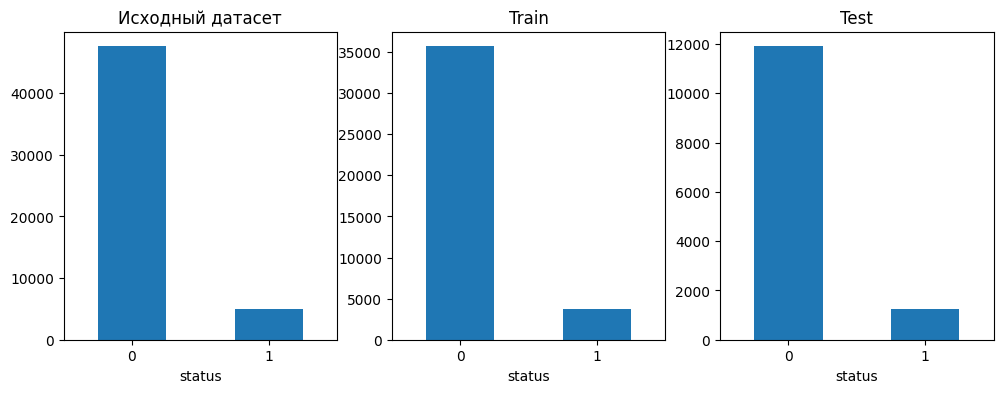

In [68]:
# выделяем в отдельные переменные целевой признак и входные признаки
X = train.drop(columns=['status'], axis=1)
y = train['status']

# разбиваем данные на выборки с учётом стратификации по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

# визуализируем баланс целевого признака в выборках
fig, ax = plt.subplots(1,3, figsize=(12,4))
y.value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title("Исходный датасет")
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title("Train")
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0)
ax[2].set_title("Test")
plt.show()

In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39386 entries, 22289 to 19394
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   category_list         39386 non-null  object 
 1   funding_total_usd     39386 non-null  float64
 2   country_code          39386 non-null  object 
 3   funding_rounds        39386 non-null  int64  
 4   last_funding_at_days  39386 non-null  int64  
 5   lifetime              39386 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.1+ MB


In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52515 entries, 0 to 52515
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   category_list         52515 non-null  object 
 1   funding_total_usd     52515 non-null  float64
 2   status                52515 non-null  int64  
 3   country_code          52515 non-null  object 
 4   funding_rounds        52515 non-null  int64  
 5   last_funding_at_days  52515 non-null  int64  
 6   lifetime              52515 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 3.2+ MB


In [71]:
train['status'] = train['status'].astype(int)

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52515 entries, 0 to 52515
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   category_list         52515 non-null  object 
 1   funding_total_usd     52515 non-null  float64
 2   status                52515 non-null  int64  
 3   country_code          52515 non-null  object 
 4   funding_rounds        52515 non-null  int64  
 5   last_funding_at_days  52515 non-null  int64  
 6   lifetime              52515 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 3.2+ MB


In [73]:
#списки с названиями признаков
ohe_columns = ['category_list', 'country_code']
ohe_columns

['category_list', 'country_code']

In [74]:
num_columns = ['funding_total_usd',
               'funding_rounds',
               'lifetime',
               'last_funding_at_days']
num_columns

['funding_total_usd', 'funding_rounds', 'lifetime', 'last_funding_at_days']

In [75]:
y_train.dtype

dtype('int64')

In [77]:
# SimpleImputer + OHE
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

In [78]:
num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),  # Место для гиперпараметров StandardScaler, MinMaxScaler, RobustScaler
])

In [79]:
 %%time

# кодируем целевой признак
#label_encoder = LabelEncoder()
#label_encoder.fit(y_train)

#y_train = label_encoder.transform(y_train)
#y_test = label_encoder.transform(y_test)

# создаем экземпляр класса RandomOverSampler с фиксированным random_state
sampler = RandomOverSampler(random_state=RANDOM_STATE)

# сэмплируем данные методов оверсэмплинга одной командой
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
X_test_sampled, y_test_sampled = sampler.fit_resample(X_test, y_test)


 # создаём общий пайплайн для подготовки данных
 data_preprocessor = ColumnTransformer(
     [('ohe', ohe_pipe, ohe_columns),
      ('num', num_pipe, num_columns)
     ],
     remainder='passthrough'
 )

 # создаём итоговый пайплайн для обучения модели
 pipe_final = Pipeline(
     [
         ('preprocessor', data_preprocessor),
         ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)),
     ]
 )

 param_grid = [
     # словарь для модели DecisionTreeClassifier()
     {
         'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
         'models__max_depth': range(2, 5),
         'models__max_features': range(2, 5),
         'preprocessor__num': [StandardScaler(), MinMaxScaler()]
     },

     # словарь для модели KNeighborsClassifier()
     {
         'models': [KNeighborsClassifier()],
         'models__n_neighbors': range(2, 5),
         'preprocessor__num': [StandardScaler(), MinMaxScaler()]
     },

     # словарь для модели LogisticRegression()
     {
         'models': [LogisticRegression(
             random_state=RANDOM_STATE,
             solver='liblinear',
             penalty='l1'
         )],
         'models__C': range(1, 10),
         'preprocessor__num': [StandardScaler(), MinMaxScaler()]
     },

 ]

 # выберем лучшую модель и параметры с помощью RandomizedSearchCV()
 # количество комбинаций гиперпараметров поставим 5
 randomized_search = RandomizedSearchCV(
     pipe_final,
     param_grid,
     cv=5,
     scoring='f1',
     n_iter=5,
     random_state=RANDOM_STATE,
     n_jobs=-1
 )
 # обучаем лучшую модель на тренировочных данных
 randomized_search.fit(X_train_sampled, y_train_sampled)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU times: user 16.4 s, sys: 2.02 s, total: 18.5 s
Wall time: 1min 28s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['category_list',
                                                                                'country_code']),
                                                                              ('num',
                                                                               Pipeline(steps=[('simpleImp...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(C=1,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='f1')

In [80]:
%%time
y_train_pred = randomized_search.best_estimator_.fit(X_train_sampled, y_train_sampled).predict(X_train_sampled) #предсказанные значения классов
y_train_pred_prob = randomized_search.best_estimator_.predict_proba(X_train_sampled)[:,1]
y_train_pred_prob[:10]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU times: user 10.6 s, sys: 2.97 s, total: 13.6 s
Wall time: 13.6 s


array([6.97785267e-02, 3.78528191e-01, 5.26768624e-01, 2.55611775e-01,
       4.68593829e-01, 1.31417167e-09, 4.56312151e-02, 1.15374333e-04,
       2.50789302e-01, 9.77586070e-01])

In [81]:
%%time
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)
print(f'Метрика ROC-AUC на тренировочной выборке: {roc_auc_score(y_train_sampled, y_train_pred_prob)}')
print(f'Метрика F1 на тренировочной выборке: {f1_score(y_train_sampled, y_train_pred, average="macro")}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['category_list',
                                                   'country_code']),
                                                 ('num', MinMaxScaler(),
                                     

In [82]:
%%time
y_test_pred = randomized_search.best_estimator_.predict(X_test_sampled)
y_test_pred_prob = randomized_search.best_estimator_.predict_proba(X_test_sampled)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_sampled, y_test_pred_prob)}')
print(f'Метрика F1 на тестовой выборке: {f1_score(y_test_sampled, y_test_pred, average="macro")}')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Метрика ROC-AUC на тестовой выборке: 0.9193586964197443
Метрика F1 на тестовой выборке: 0.8645431025772119
CPU times: user 432 ms, sys: 650 ms, total: 1.08 s
Wall time: 1.2 s


In [83]:
#train.info()

# Анализ важности

In [84]:
features_names = randomized_search.best_estimator_.named_steps.preprocessor.get_feature_names_out()

<Axes: ylabel='Feature'>

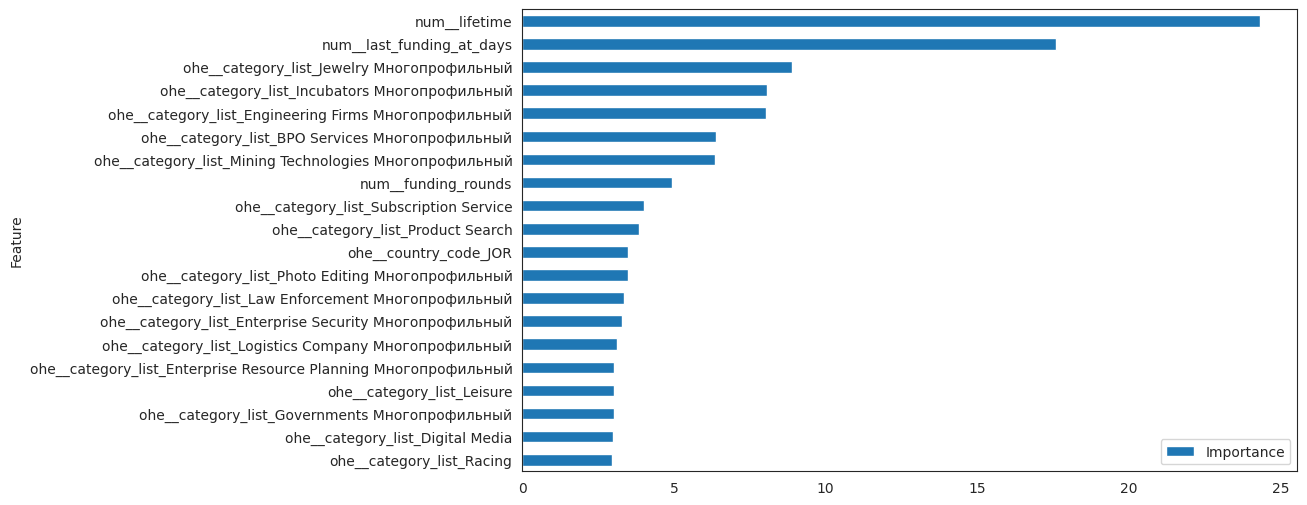

In [85]:
coefficients = randomized_search.best_estimator_.named_steps.models.coef_[0]
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance',ascending=True).tail(20)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## Приведем тестовый датасет в соответствие с тренировочным

In [86]:
dataframe_info(test)

DataFrame shape  : 13125 rows, 13 columns
Memory usage     : 1.30 MB
Duplicates count : 0


,notNA,"notNA, %",dtype
name,13125,100.00,object
category_list,13125,100.00,object
funding_total_usd,13125,100.00,float64
country_code,13125,100.00,object
state_code,11430,87.09,object
region,11536,87.89,object
city,11538,87.91,object
funding_rounds,13125,100.00,int64
first_funding_at,13125,100.00,datetime64[ns]
last_funding_at,13125,100.00,datetime64[ns]


In [87]:
test_columns_drop = ['name', 'state_code', 'region', 'city', 'first_funding_at', 'last_funding_at', 'last_funding_at_date']

In [88]:
test_final = test.drop(test_columns_drop, axis=1)

In [89]:
dataframe_info(test_final)

DataFrame shape  : 13125 rows, 6 columns
Memory usage     : 0.60 MB
Duplicates count : 2


,notNA,"notNA, %",dtype
category_list,13125,100.00,object
funding_total_usd,13125,100.00,float64
country_code,13125,100.00,object
funding_rounds,13125,100.00,int64
lifetime,13125,100.00,int64
last_funding_at_days,13125,100.00,int64


In [90]:
# Проверим, что столбцы в тестовом наборе данных соответствуют столбцам в тренировочном наборе данных
print(X_train_sampled.columns)
print(test_final.columns)

Index(['category_list', 'funding_total_usd', 'country_code', 'funding_rounds',
       'last_funding_at_days', 'lifetime'],
      dtype='object')
Index(['category_list', 'funding_total_usd', 'country_code', 'funding_rounds',
       'lifetime', 'last_funding_at_days'],
      dtype='object')


In [91]:
#Поправим порядок столбцов
test_final = test_final[X_train_sampled.columns]
test_final.sample(5)

,category_list,funding_total_usd,country_code,funding_rounds,last_funding_at_days,lifetime
3800,Business Services Многопрофильный,81438.0,EST,2,13561,761
8712,Hospitality,5000000.0,USA,1,12168,5479
10314,Software,3000000.0,USA,1,14772,1826
3250,Banking Многопрофильный,31000000.0,USA,2,12983,8766
7801,Clean Technology,40000.0,USA,1,14711,5479


In [93]:
test['status'] = randomized_search.best_estimator_.predict(test_final)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [94]:
submit = test[['name','status']]

In [95]:
submit

,name,status
0,Crystalsol,0
1,JBI Fish & Wings,0
2,COINPLUS,0
3,Imagine Communications,0
4,DNA13,0
...,...,...
13120,Jymob,0
13121,GlobaTrek,0
13122,Inkd.com,0
13123,AdWill,0


In [96]:
submit['status'] = submit['status'].apply( lambda x: 'operating' if x == 0 else 'closed')

<ipython-input-96-38f43df27f76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['status'] = submit['status'].apply( lambda x: 'operating' if x == 0 else 'closed')


In [97]:
submit

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


In [98]:
#submit = submit.set_index('name')

In [99]:
#submit.to_csv('kaggle_startups_submit3_.csv', index= False)

In [100]:
submit.to_csv('submit2.csv', index=False)

In [101]:
#pd.read_csv('kaggle_startups_submit3_.csv')

In [102]:
pd.read_csv('submit2.csv')

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating
